# <span style="color:navy"> Numerical Simulation Laboratory
# <span style="color:orange"> Numerical Exercises 07
### Monte Carlo NVT

This exercise's aim was to simulate the same system we did in *Molecular Dynamics*, a *N = 108* particles in a Lennard-Jones potential, by fixing the temperature and sampling the position with Metropolis algorithm.. In this exercise too we were given a code to improve and complete.  
Firtstly, though, a study of autocorrelation in the blocks is needed, since Metropolis is a Markov chain and correlation could be strong between near steps.

***Autocorrelation***  
The autocorrelation function is defined as:
$$ \chi(\tau) = 
\frac{\langle x(t)\,x(t+\tau)\rangle  - \langle x(t)\rangle \langle x(t+\tau)\rangle}{{\sigma^2}_x} $$
where x(t) are the positions at time t (in a Metropolis simulation t are discretized and coincide with steps) and ${\sigma^2}_x$ is the variance of the dataset used to compute autocorrelation. I implemented a python script to compute autocorrelation using a dataset of 100000 istantaneous values for energy and pressure (the simulation had 101000 steps in total but in reading the file the first 1000 steps are skipped since the system needs to reach the equilibrium to have significant measures). The autocorrelation here is computed for values of $\tau$ from 1 to 500. 
It is important to know when autocorrelation vanishes because it gives a good indication on how large should the blocks be, in order to have a real estimation of the error.

Since printing istantaneous value costs in computational time and is not necessary for the simulation itself, but only in preliminary studies, after producing the useful data, the function which writes this values (*PrintMeasure()*) has been commented. 

In the following pictures there are the interesting plots of autocorrelation function for both properties in the three phases:solid, liquid and gas. They clearly shows that for each phase there' a value of steps after which the autocorrelation vanishes completely; this values are approximately *100* for solud, *250* for liquid and only *20* for gas phase; this means that with blocks much larger than these values, let's say for example of *5000* steps, the correlation between blocks will be limited to the very border, and does not affect importantly the error neither the average. One may also note that autocorrelation decays as an exponential $N\,e^{-t/t_c}$ where an estimation of the values for the two parameters $N,\;t_c$ is given from a fit.

In [1]:
# figures parameters
import matplotlib as mpl
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['figure.subplot.wspace'] = 0.2
mpl.rcParams['figure.subplot.hspace']= 0.4

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def mean (x, size):
    ave = 0
    for i in range(0,size):
        ave = ave + x[i]
    return ave/size

def error (x, size):
    ave = mean (x,size)
    ave2 = mean (x*x, size)
    return ave2 - ave**2

#calculate autocorrelation of vector x for a number of value from 1 to size 
def autocorr (x,size):
    auto = np.zeros(size)
    ave = mean(x, x.size-size)
    sigma = error(x, x.size)

    for m in range(0,size):
        covxx = 0
        meanplus = 0
        for t in range(0, x.size-size):
            covxx = covxx + x[t]*x[t+m]
            meanplus = meanplus + x[t+m]
        meanplus = meanplus/(x.size-size)
        covxx = covxx/(x.size - size)
        auto[m] = (covxx - meanplus*ave)/sigma
    return auto            


s_epot= np.loadtxt ("MonteCarlo_NVT/Autocorrelation/Solid/ist_epot.dat", usecols=(1), delimiter='\t', skiprows=1000)
s_press = np.loadtxt ("MonteCarlo_NVT/Autocorrelation/Solid/ist_press.dat", usecols=(1), skiprows=1000)
l_epot= np.loadtxt ("MonteCarlo_NVT/Autocorrelation/Liquid/ist_epot.dat", usecols=(1), delimiter='\t', skiprows=1000)
l_press = np.loadtxt ("MonteCarlo_NVT/Autocorrelation/Liquid/ist_press.dat", usecols=(1), skiprows=1000)
g_epot= np.loadtxt ("MonteCarlo_NVT/Autocorrelation/Gas/ist_epot.dat", usecols=(1), delimiter='\t', skiprows=1000)
g_press = np.loadtxt ("MonteCarlo_NVT/Autocorrelation/Gas/ist_press.dat", usecols=(1), skiprows=1000)

ac_s_epot = autocorr(s_epot,500)
ac_s_press = autocorr (s_press,500)
ac_l_epot = autocorr(l_epot,500)
ac_l_press = autocorr (l_press,500)
ac_g_epot = autocorr(g_epot,500)
ac_g_press = autocorr (g_press,500)

Solid epot [N, t_c] [ 0.88619626 10.25233509]
Solid press [N, t_c] [ 0.88708191 10.1307331 ]
Liquid epot [N, t_c] [ 0.68058515 18.11608547]
Liquid press [N, t_c] [ 0.66983704 23.41964978]
Gas epot [N, t_c] [0.9479902 2.9694147]
Gas press [N, t_c] [0.99771394 0.85745011]


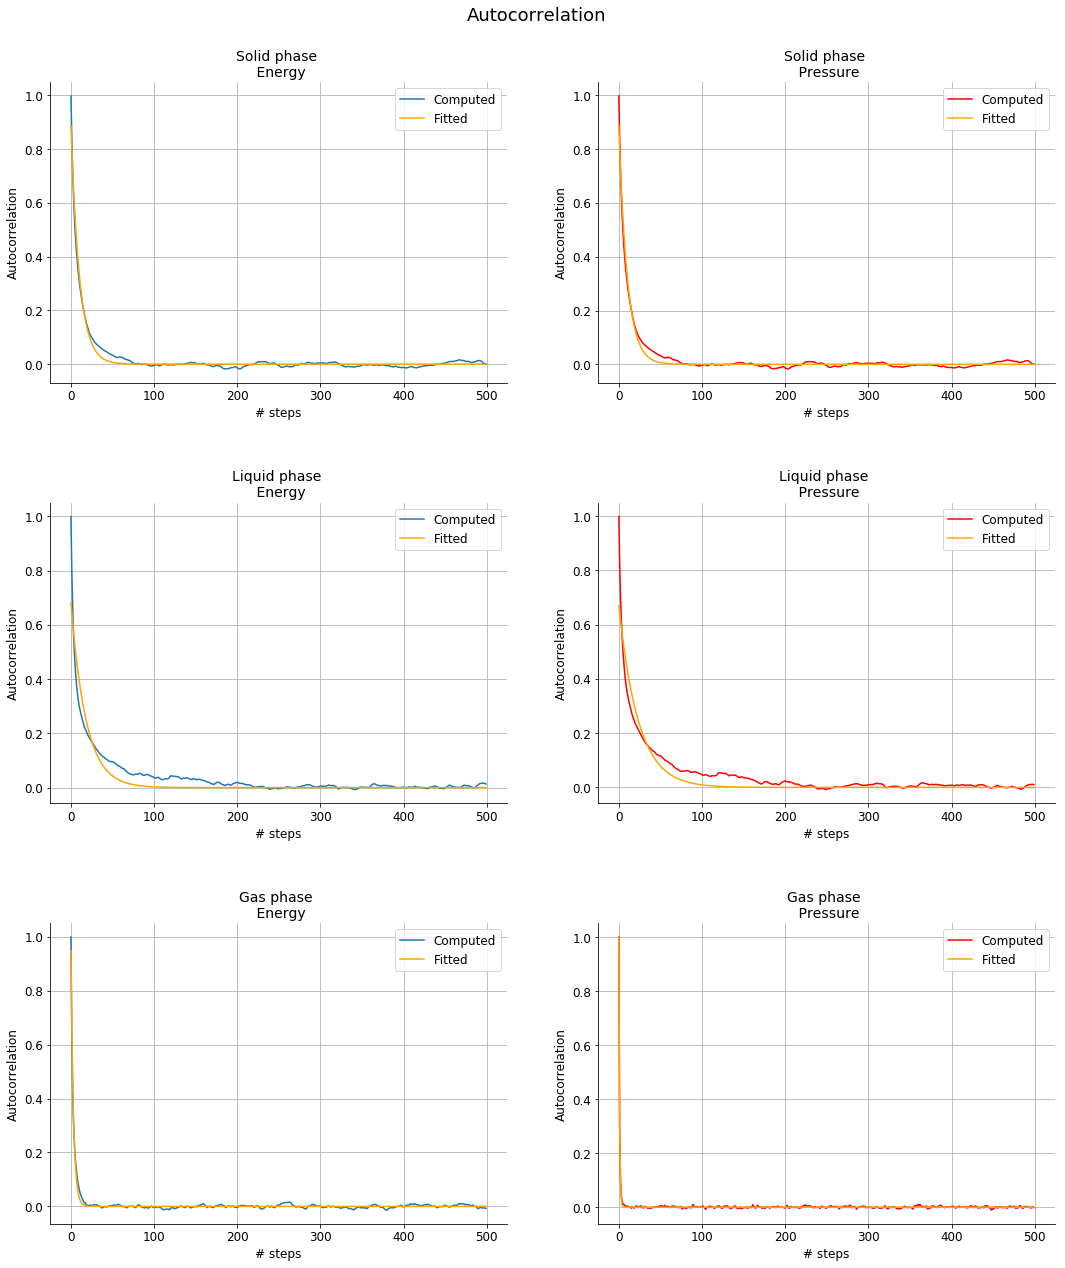

In [2]:
from scipy.optimize import curve_fit
def f (x,a, tau):
    return a*np.exp(-x/tau)

fig, axarr = plt.subplots (3 ,2, figsize=(18,21))
fig.suptitle("Autocorrelation", y=0.93)

n = np.arange (0, ac_s_epot.size)

#Solid phase

axarr[0,0].plot (n, ac_s_epot, label  = "Computed")
axarr[0,0].set_title ("Solid phase \n Energy")
axarr[0,1].plot (n, ac_s_press, label  = "Computed", c = 'red')
axarr[0,1].set_title ("Solid phase \n Pressure")

#fit parameters
p_opt, p_cov = curve_fit (f, n, ac_s_epot)
y_fit = f(n, p_opt[0], p_opt[1])
axarr[0,0].plot(n,y_fit, c='orange', label="Fitted")

print("Solid epot [N, t_c]", p_opt)

#fit parameters
p_opt, p_cov = curve_fit (f, n, ac_s_press)
y_fit = f(n, p_opt[0], p_opt[1])
axarr[0,1].plot(n,y_fit, c='orange', label="Fitted")

print("Solid press [N, t_c]", p_opt)


#Liquid phase

axarr[1,0].plot (n, ac_l_epot, label  = "Computed")
axarr[1,0].set_title ("Liquid phase \n Energy")
axarr[1,1].plot (n, ac_l_press, label  = "Computed", c = 'red')
axarr[1,1].set_title ("Liquid phase \n Pressure")

#fit parameters
p_opt, p_cov = curve_fit (f, n, ac_l_epot)
y_fit = f(n, p_opt[0], p_opt[1])
axarr[1,0].plot(n,y_fit, c='orange', label="Fitted")

print("Liquid epot [N, t_c]", p_opt)

#fit parameters
p_opt, p_cov = curve_fit (f, n, ac_l_press)
y_fit = f(n, p_opt[0], p_opt[1])
axarr[1,1].plot(n,y_fit, c='orange', label="Fitted")

print("Liquid press [N, t_c]", p_opt)


#Gas phase

axarr[2,0].plot (n, ac_g_epot, label  = "Computed")
axarr[2,0].set_title ("Gas phase \n Energy")
axarr[2,1].plot (n, ac_g_press, label  = "Computed", c = 'red')
axarr[2,1].set_title ("Gas phase \n Pressure")

#fit parameters
p_opt, p_cov = curve_fit (f, n, ac_g_epot)
y_fit = f(n, p_opt[0], p_opt[1])
axarr[2,0].plot(n,y_fit, c='orange', label="Fitted")

print("Gas epot [N, t_c]", p_opt)

#fit parameters
p_opt, p_cov = curve_fit (f, n, ac_g_press)
y_fit = f(n, p_opt[0], p_opt[1])
axarr[2,1].plot(n,y_fit, c='orange', label="Fitted")

print("Gas press [N, t_c]", p_opt)

for i in range(3):
    for j in range(2):
        axarr[i, j].set_xlabel ('# steps')
        axarr[i, j].set_ylabel("Autocorrelation")
        axarr[i, j].grid(True)
        axarr[i, j].legend()

plt.show()

***Statistical error***  
Another important property on which block length is influent is the statistical uncertainty: a too short block may not be enough to have reasonable statistic, therefore it won't be reliable, on the other hand too long blocks cost computational time, that could be used in another way. For this reason, using the previous dataset of instantaneous values I computed the expected values for block uncertainties with different block lengths. It can be done with a python script that divides the measures in blocks, accumulates the squared means of blocks and at the end computes the statistical error one would obtain with data blocking:
$$
\sigma = \sqrt{\frac{\langle  x^2\rangle - \langle x \rangle^2}{N-1}}
$$
Where $x$ is the mean value of a property a block and $N$ the total number of blocks.

In the following pictures are the expected values for the error if dividing the instantaneous values, already used to compute autocorrelation, in *N* blocks each of *L = 100000/N* steps, as a function of *L*. Again the behaviour results very different for different phases. For solid phase *1000* points per block is yet a good number, as the error is stable (i.e. has no trend) and this means that it is not understimated beacuse of little statistic and the same happens for gas phase at even shorter block (let's say *200* is enough); for liquid instead it is sligthly different as it has a growing trend until *5000* steps per block. This is in perfect agreement to the value at which correlation vanishes for three phases: the earlier (in time steps) it goes to zero, the lesser the number of steps required in a single block. This happens because as said before autocorrelation brings an underestimation of the error, since values are correlated their variance seems lesser than it really is.

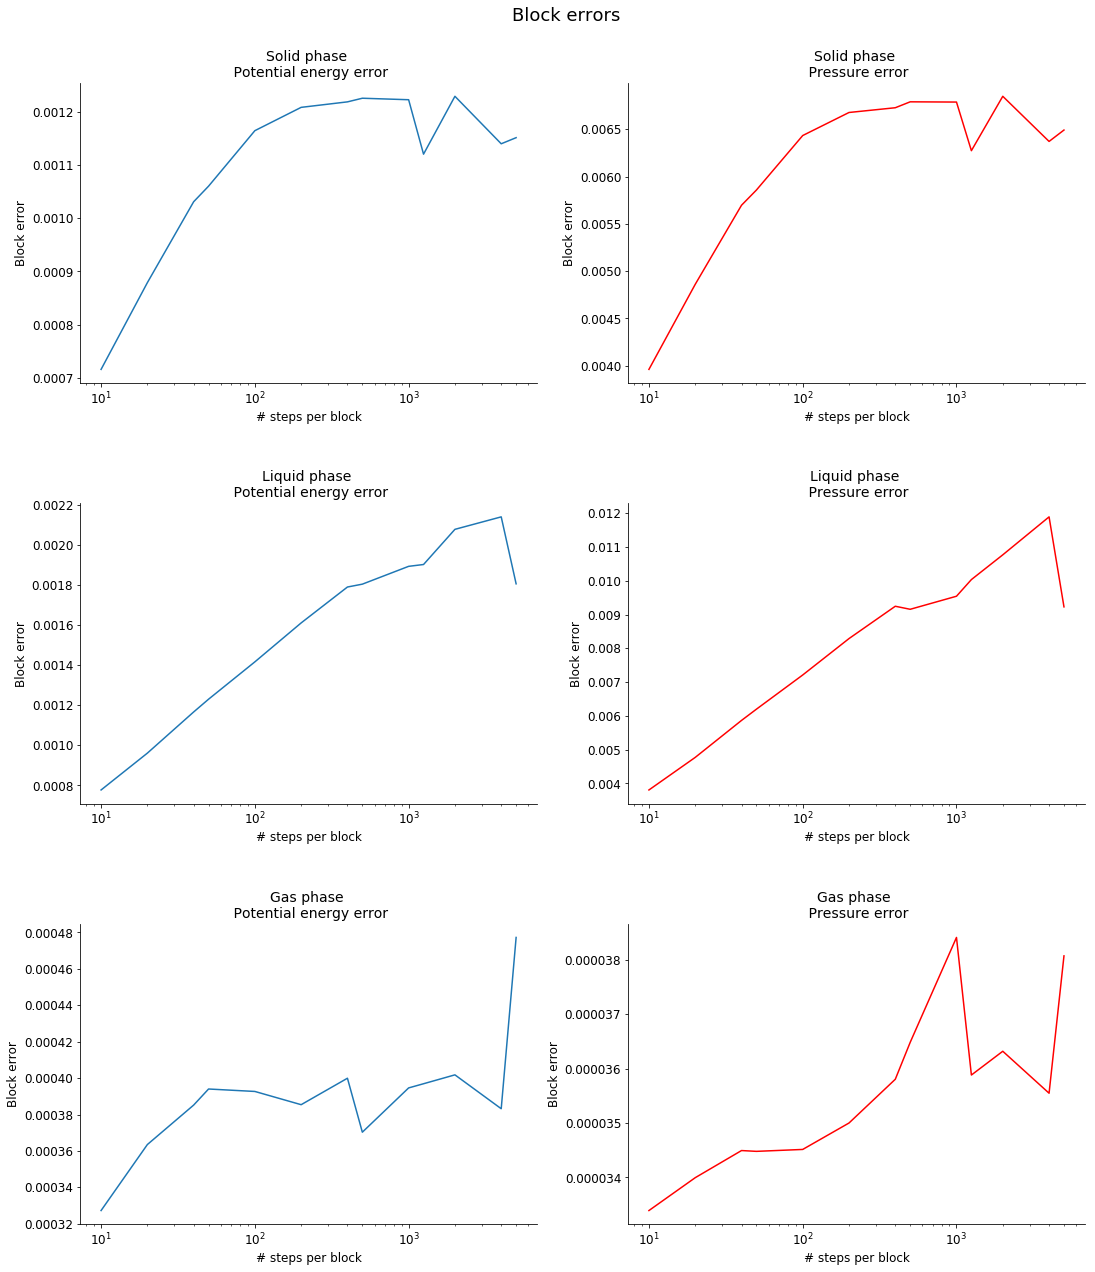

In [3]:
#statistical uncertainties study
def stat_error (x, L):
    #x array type: set of values
    #L integer type: number of values in a block
    #check everything is fine
    assert x.size%L == 0
    N = x.size/L
    N = int(N)
    ave = mean(x,x.size)
    ave_2 = 0
    for i in range(0,N):
        ave_2 = ave_2 + mean(x[i*L:(i+1)*L:1],L)**2
    ave_2 = ave_2/N
    #returns statistical error with data blocking method for L steps per block
    return ((ave_2-ave**2)/(N-1))**0.5
        
L_values = [10,20,40,50,100,200,400,500,1000,1250, 2000,4000, 5000]

#Solid phase
s_epot_err = np.array([
    stat_error(s_epot,L)
    for L in L_values
])

s_press_err = np.array([
    stat_error(s_press,L)
    for L in L_values
])

#Liquid phase
l_epot_err = np.array([
    stat_error(l_epot,L)
    for L in L_values
])

l_press_err = np.array([
    stat_error(l_press,L)
    for L in L_values
])

#Gas phase
g_epot_err = np.array([
    stat_error(g_epot,L)
    for L in L_values
])

g_press_err = np.array([
    stat_error(g_press,L)
    for L in L_values
])

fig, axarr = plt.subplots (3 ,2, figsize=(18,21))
fig.suptitle("Block errors", y=0.93)
axarr[0,0].semilogx (L_values, s_epot_err)
axarr[0,1].semilogx (L_values, s_press_err, c='red')
axarr[0,0].set_title("Solid phase \n Potential energy error")
axarr[0,1].set_title("Solid phase \n Pressure error")

axarr[1,0].semilogx (L_values, l_epot_err)
axarr[1,1].semilogx (L_values, l_press_err, c='red')
axarr[1,0].set_title("Liquid phase \n Potential energy error")
axarr[1,1].set_title("Liquid phase \n Pressure error")

axarr[2,0].semilogx (L_values, g_epot_err)
axarr[2,1].semilogx (L_values, g_press_err, c='red')
axarr[2,0].set_title("Gas phase \n Potential energy error")
axarr[2,1].set_title("Gas phase \n Pressure error")

for i in range(3):
    for j in range(2):
        axarr[i, j].set_xlabel ('# steps per block')
        axarr[i, j].set_ylabel("Block error")
                               
plt.show()

***NVT simulation***  
To do the simulation for *Argon* and *Kripton* similarly to what I did for *Molecular Dynamics* I add to the code the option of *realsimulation* which writes in a directory with the name of the element the files with average values and uncertanties.  Before doing the simulation, though, it  could be necessary to equilibrate the system, for this reason I add the possibility also to restart from the last reached configuration. By the way since I used a very large number of steps (*20* blocks of *6000* steps, for *M=120000* total steps), and equilibration time is very short (*~1000* steps), I evaluated that these steps will not affect final results if not running first equilibration steps and then restart, so my simulation are made of a unique run from *FCC* onward. The proof that equilibration time is short can be seen in the first two following plots where I show istantaneous values of the first *5000* steps for the three phases, it stands out that almost immediately they come to equilibrium.  
The code we were provided had already implemented the calculation of potential energy and of pressure, even with tail corrections. These are corrections needed beacuse in the measures of thermodynamical properties a cut-off radius is introduced and therefore it is useful to correct the values compensating for the long-range interaction neglected.

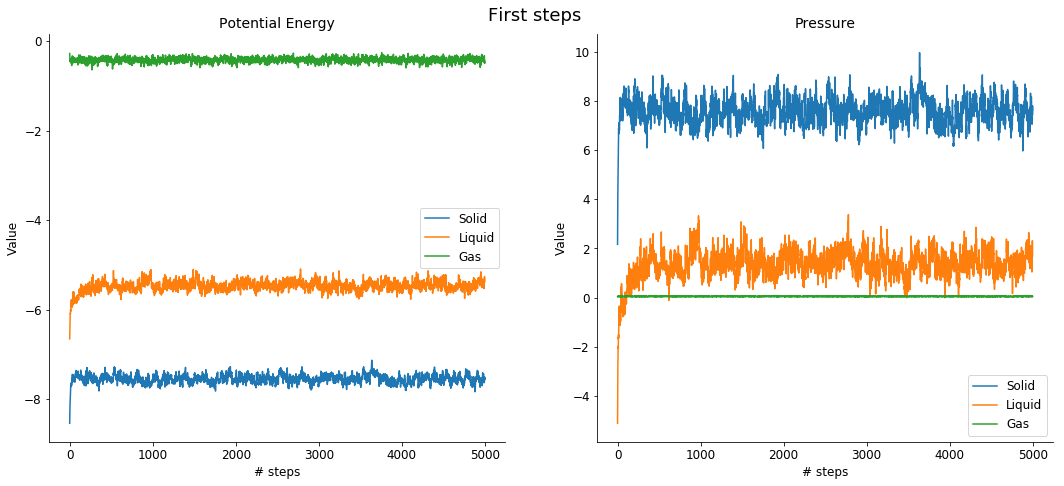

In [4]:
s_epot= np.loadtxt ("MonteCarlo_NVT/Autocorrelation/Solid/ist_epot.dat", usecols=(1), delimiter='\t', max_rows=5000)
s_press = np.loadtxt ("MonteCarlo_NVT/Autocorrelation/Solid/ist_press.dat", usecols=(1), max_rows=5000)
l_epot= np.loadtxt ("MonteCarlo_NVT/Autocorrelation/Liquid/ist_epot.dat", usecols=(1), delimiter='\t', max_rows=5000)
l_press = np.loadtxt ("MonteCarlo_NVT/Autocorrelation/Liquid/ist_press.dat", usecols=(1), max_rows=5000)
g_epot= np.loadtxt ("MonteCarlo_NVT/Autocorrelation/Gas/ist_epot.dat", usecols=(1), delimiter='\t', max_rows=5000)
g_press = np.loadtxt ("MonteCarlo_NVT/Autocorrelation/Gas/ist_press.dat", usecols=(1), max_rows=5000)


fig, axarr = plt.subplots (1 ,2, figsize=(18,7.5))
fig.suptitle("First steps", y=0.93)

n = np.arange(s_epot.size)
axarr[0].plot(n, s_epot, label='Solid')
axarr[0].plot(n, l_epot, label='Liquid')
axarr[0].plot(n, g_epot, label='Gas')
axarr[0].set_title('Potential Energy')
axarr[0].set_xlabel("# steps")
axarr[0].set_ylabel("Value")
axarr[0].legend()

axarr[1].plot(n, s_press, label='Solid')
axarr[1].plot(n, l_press, label='Liquid')
axarr[1].plot(n, g_press, label='Gas')
axarr[1].set_title('Pressure')
axarr[1].set_xlabel("# steps")
axarr[1].set_ylabel("Value")
axarr[1].legend()
plt.show()

Following are the pictures of average values for potential energy and pressure, obtained by a simulation of *N = 20* blocks, each of *L = 6000* steps, the choice given by the observations yet done. They are shown with the statistical uncertainty as usual given by data blocking. All values are presented in *SI* unis, using the following typical properties:  
$Argon$  
$\sigma = 0.34$ $ nm$  
$\frac{\epsilon}{k_B} = 120$ $K $  
$m = 39.984$ $amu $

$Kripton$  
$\sigma = 0.364$ $ nm$  
$\frac{\epsilon}{k_B} = 164$ $K $  
$m = 83.798$ $amu $

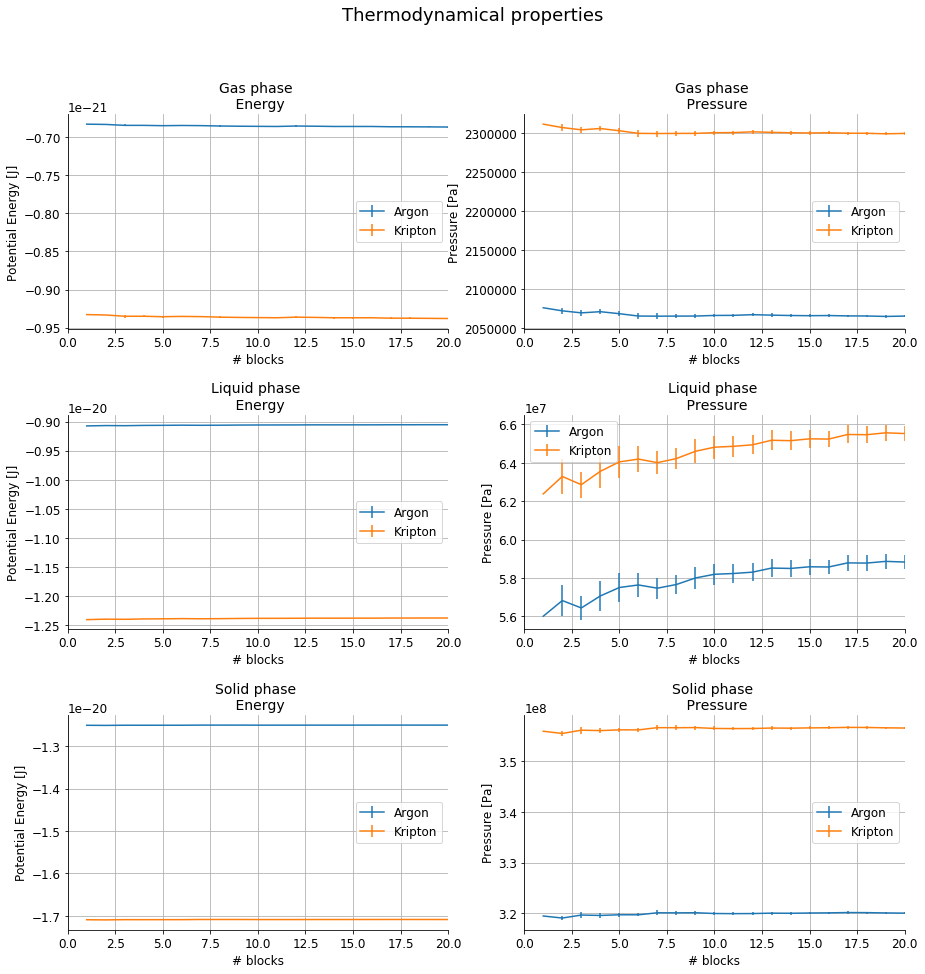

In [5]:
fig, axarr = plt.subplots (3 ,2, figsize=(15,15))
fig.suptitle("Thermodynamical properties")

#gas
blk, a_epot, a_epot_err = np.loadtxt("MonteCarlo_NVT/Argon/Gas/Argon_output.epot.dat", usecols=(0, 1, 2), unpack=True)
k_epot, k_epot_err= np.loadtxt("MonteCarlo_NVT/Kripton/Gas/Kripton_output.epot.dat", usecols=(1, 2), unpack=True)
axarr[0,0].errorbar(blk, a_epot, yerr=a_epot_err, label='Argon')
axarr[0,0].errorbar(blk, k_epot, yerr=k_epot_err, label='Kripton')
axarr[0,0].set_title ("Gas phase \n Energy")

blk, a_press, a_press_err = np.loadtxt("MonteCarlo_NVT/Argon/Gas/Argon_output.press.dat", usecols=(0, 1, 2), unpack=True)
k_press, k_press_err= np.loadtxt("MonteCarlo_NVT/Kripton/Gas/Kripton_output.press.dat", usecols=(1, 2), unpack=True)
axarr[0,1].errorbar(blk, a_press, yerr=a_press_err, label='Argon')
axarr[0,1].errorbar(blk, k_press, yerr=k_press_err, label='Kripton')
axarr[0,1].set_title ("Gas phase \n Pressure")

axarr[0,0].set_ylabel("Potential Energy [J]")
axarr[0,1].set_ylabel("Pressure [Pa]")

#liquid
blk, a_epot, a_epot_err = np.loadtxt("MonteCarlo_NVT/Argon/Liquid/Argon_output.epot.dat", usecols=(0, 1, 2), unpack=True)
k_epot, k_epot_err= np.loadtxt("MonteCarlo_NVT/Kripton/Liquid/Kripton_output.epot.dat", usecols=(1, 2), unpack=True)
axarr[1,0].errorbar(blk, a_epot, yerr=a_epot_err, label='Argon')
axarr[1,0].errorbar(blk, k_epot, yerr=k_epot_err, label='Kripton')
axarr[1,0].set_title ("Liquid phase \n Energy")

blk, a_press, a_press_err = np.loadtxt("MonteCarlo_NVT/Argon/Liquid/Argon_output.press.dat", usecols=(0, 1, 2), unpack=True)
k_press, k_press_err = np.loadtxt("MonteCarlo_NVT/Kripton/Liquid/Kripton_output.press.dat", usecols=(1, 2), unpack=True)
axarr[1,1].errorbar(blk, a_press, yerr=a_press_err, label='Argon')
axarr[1,1].errorbar(blk, k_press, yerr=k_press_err, label='Kripton')
axarr[1,1].set_title ("Liquid phase \n Pressure")


axarr[1,0].set_ylabel("Potential Energy [J]")
axarr[1,1].set_ylabel("Pressure [Pa]")

#solid
blk, a_epot, a_epot_err = np.loadtxt("MonteCarlo_NVT/Argon/Solid/Argon_output.epot.dat", usecols=(0, 1, 2), unpack=True)
k_epot, k_epot_err= np.loadtxt("MonteCarlo_NVT/Kripton/Solid/Kripton_output.epot.dat", usecols=(1, 2), unpack=True)
axarr[2,0].errorbar(blk, a_epot, yerr=a_epot_err, label='Argon')
axarr[2,0].errorbar(blk, k_epot, yerr=k_epot_err, label='Kripton')
axarr[2,0].set_title ("Solid phase \n Energy")

blk, a_press, a_press_err = np.loadtxt("MonteCarlo_NVT/Argon/Solid/Argon_output.press.dat", usecols=(0, 1, 2), unpack=True)
k_press, k_press_err= np.loadtxt("MonteCarlo_NVT/Kripton/Solid/Kripton_output.press.dat", usecols=(1, 2), unpack=True)
axarr[2,1].errorbar(blk, a_press, yerr=a_press_err, label='Argon')
axarr[2,1].errorbar(blk, k_press, yerr=k_press_err, label='Kripton')
axarr[2,1].set_title ("Solid phase \n Pressure")

axarr[2,0].set_ylabel("Potential Energy [J]")
axarr[2,1].set_ylabel("Pressure [Pa]")

for i in range(3):
    for j in range(2):
        axarr[i,j].set_xlabel("# blocks")
        axarr[i,j].set_xlim((0,20))
        axarr[i,j].grid(True)
        axarr[i,j].legend()
plt.show()

***Radial distribution***  
In addition to the implementation of the pyhton scripts for studying block lengths it was asked to add the computation of radial distribution: the probability of finding a pair of atoms at a distance *r* apart, compared to the probablity expected for an ideal gas at the same density. I evaluated this radial distribution (from now on it will be *g(r)*) in the interval $\left[0, \frac{L}{2}\right]$ for reason of simmetry, as working in periodic boundaries conditions allows to have distance *r* lesser than $\frac{L}{2}$ on the direction parallel to the edge of simulation box, but would allow distances up to $\frac{\sqrt2\, L}{2}$ on the diagonal direction, so I took the lesser one. I divided the interval in *100* bins and counted for each step the number of particles separated for a quantity $r_i < r < r_{i+1}$, with $r_j$ edges of the bin, increasing the counter for the respective bin. At the end of a block, after taking the average number of particles in a given bin, the value of *g(r)* , where *r* is he mean value of the bin, is given by:
$$
g(r) = 
\frac{\langle N_{all}(r)\rangle}{N_{tot}}\frac{1}{\rho\,V(r)} = 
\frac{\langle N_{one}(r)\rangle}{N_{ideal}(r)}
$$
Where $\langle N_{all}(r)\rangle$ is the mean of the sum over all couples of particles of the particles at a distance *r*, therefore if divided per $N_{tot}$ it is the mean of the particle at a distance *r* from one given particle.

In the following picture are plotted the values of *g(r)* for both elements in the three different phases, comparing results obtained via MonteCarlo_NVT and Molecular Dynamics code. The data seems in perfect agreement for liquid and solid phase, while they are not for gas phase. I suspect that this can be motivated because I use the same *dt* for all phases hin MD, but in gas phase, particles are far speeder and this may brings a greater error in the extimation of the position while calculating it from the motion equation. This problem is avoided in Metropolis since it does not sample the real trajectory, but only tends to sample the real distribution of probability so it is independent from the velocity the particles are moving with. 

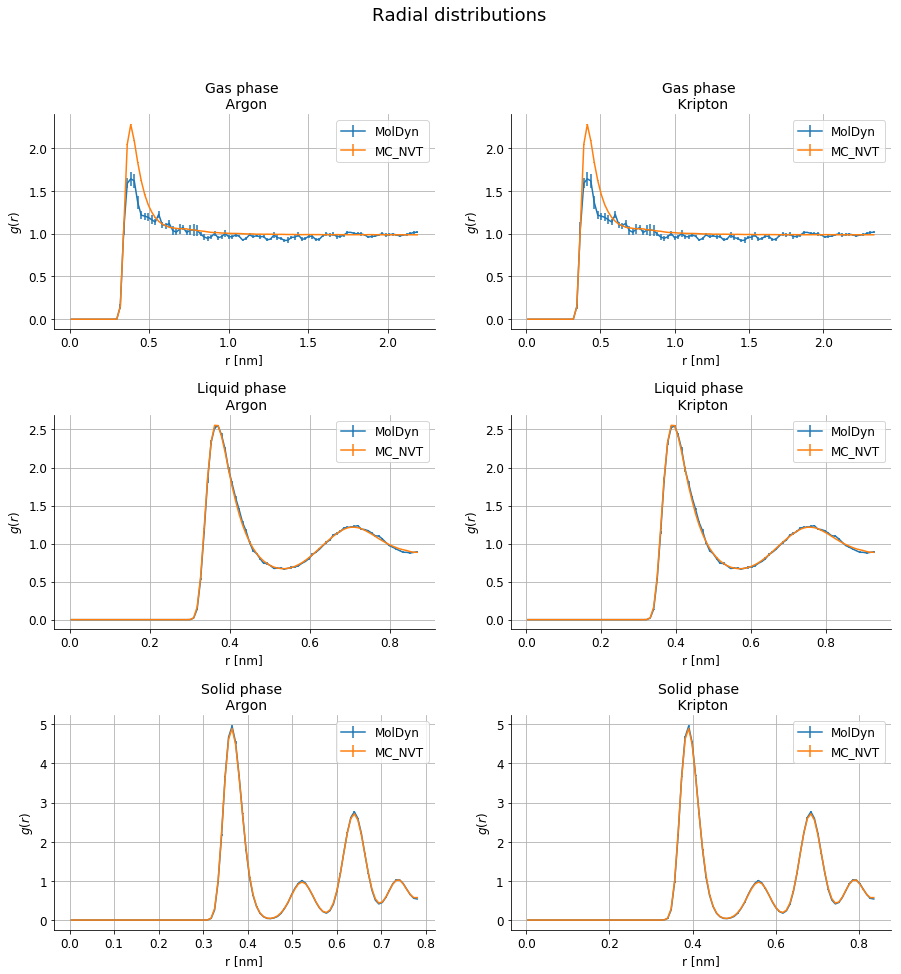

In [6]:
#g(r)
fig, axarr = plt.subplots (3 ,2, figsize=(15,15))
fig.suptitle("Radial distributions")

#gas
r, gofr , error= np.loadtxt("../Exercises04/MolecularDynamics_NVE/Argon/Gas/Argon_Ave_gofr.out", usecols=(1, 2, 3), unpack=True, skiprows = 400)
met_r, met_gofr , met_error= np.loadtxt("MonteCarlo_NVT/Argon/Gas/Argon_output.gofr.dat", usecols=(1, 2, 3), unpack=True)
axarr[0,0].errorbar(r,gofr, yerr=error, label='MolDyn')
axarr[0,0].errorbar(met_r,met_gofr, yerr=met_error, label='MC_NVT')
axarr[0,0].set_title ("Gas phase \n Argon")

r, gofr , error= np.loadtxt("../Exercises04/MolecularDynamics_NVE/Kripton/Gas/Kripton_Ave_gofr.out", usecols=(1, 2, 3), unpack=True, skiprows = 400)
met_r, met_gofr , met_error= np.loadtxt("MonteCarlo_NVT/Kripton/Gas/Kripton_output.gofr.dat", usecols=(1, 2, 3), unpack=True)
axarr[0,1].errorbar(r,gofr, yerr=error, label='MolDyn')
axarr[0,1].errorbar(met_r,met_gofr, yerr=met_error, label='MC_NVT')
axarr[0,1].set_title ("Gas phase \n Kripton")


#liquid
r, gofr , error= np.loadtxt("../Exercises04/MolecularDynamics_NVE/Argon/Liquid/Argon_Ave_gofr.out", usecols=(1, 2, 3), unpack=True, skiprows = 500)
met_r, met_gofr , met_error= np.loadtxt("MonteCarlo_NVT/Argon/Liquid/Argon_output.gofr.dat", usecols=(1, 2, 3), unpack=True)
axarr[1,0].errorbar(r,gofr, yerr=error, label='MolDyn')
axarr[1,0].errorbar(met_r,met_gofr, yerr=met_error, label='MC_NVT')
axarr[1,0].set_title ("Liquid phase \n Argon")

r, gofr , error= np.loadtxt("../Exercises04/MolecularDynamics_NVE/Kripton/Liquid/Kripton_Ave_gofr.out", usecols=(1, 2, 3), unpack=True, skiprows = 500)
met_r, met_gofr , met_error= np.loadtxt("MonteCarlo_NVT/Kripton/Liquid/Kripton_output.gofr.dat", usecols=(1, 2, 3), unpack=True)
axarr[1,1].errorbar(r,gofr, yerr=error, label='MolDyn')
axarr[1,1].errorbar(met_r,met_gofr, yerr=met_error, label='MC_NVT')
axarr[1,1].set_title ("Liquid phase \n Kripton")


#solid
r, gofr , error= np.loadtxt("../Exercises04/MolecularDynamics_NVE/Argon/Solid/Argon_Ave_gofr.out", usecols=(1, 2, 3), unpack=True, skiprows = 400)
met_r, met_gofr , met_error= np.loadtxt("MonteCarlo_NVT/Argon/Solid/Argon_output.gofr.dat", usecols=(1, 2, 3), unpack=True)
axarr[2,0].errorbar(r,gofr, yerr=error, label='MolDyn')
axarr[2,0].errorbar(met_r,met_gofr, yerr=met_error, label='MC_NVT')
axarr[2,0].set_title ("Solid phase \n Argon")

r, gofr , error= np.loadtxt("../Exercises04/MolecularDynamics_NVE/Kripton/Solid/Kripton_Ave_gofr.out", usecols=(1, 2, 3), unpack=True, skiprows = 400)
met_r, met_gofr , met_error= np.loadtxt("MonteCarlo_NVT/Kripton/Solid/Kripton_output.gofr.dat", usecols=(1, 2, 3), unpack=True)
axarr[2,1].errorbar(r,gofr, yerr=error, label='MolDyn')
axarr[2,1].errorbar(met_r,met_gofr, yerr=met_error, label='MC_NVT')
axarr[2,1].set_title ("Solid phase \n Kripton")




for i in range(3):
    for j in range(2):
        axarr[i,j].set_xlabel("r [nm]")
        axarr[i,j].set_ylabel(r"$g(r)$")
        axarr[i,j].grid(True)
        axarr[i,j].legend()
plt.show()